In [1]:
import pandas as pd
import numpy as np
import gower
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as sch

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [2]:
pre_gower = pd.read_csv('gower_input.csv')

In [3]:
pre_gower.head()

,tran_amt,principal_amt,interest_amt,new_balance,channel,tran_code,acct_type,account_active,starting_balance,ending_balance,income,age,years_with_bank,nbr_children,gender,marital_status,tran_week,region
0,0.00,0.00,0.00,3753.34,A,IQ,SV,Y,391.96,3864.77,3,3,2,0,F,1.0,42,W
1,140.63,140.63,0.00,3859.95,B,DP,SV,Y,391.96,3864.77,3,3,2,0,F,1.0,52,W
2,0.49,0.00,0.49,392.94,UNKNOWN,IN,SV,Y,391.96,3864.77,3,3,2,0,F,1.0,9,W
3,-120.00,-120.00,0.00,2253.68,A,WD,SV,Y,391.96,3864.77,3,3,2,0,F,1.0,23,W
4,-140.00,-140.00,0.00,3753.34,A,WD,SV,Y,391.96,3864.77,3,3,2,0,F,1.0,42,W


In [4]:
gower_sample = pre_gower.sample(10000, random_state=42)

In [5]:
gower_sample.head()

,tran_amt,principal_amt,interest_amt,new_balance,channel,tran_code,acct_type,account_active,starting_balance,ending_balance,income,age,years_with_bank,nbr_children,gender,marital_status,tran_week,region
25364,-178.82,-178.82,0.0,-1203.99,E,CG,CC,Y,0.00,1860.67,1,3,0,1,M,2.0,42,NE
71087,0.00,0.00,0.0,1492.04,V,IQ,CK,Y,2511.83,456.92,1,1,1,0,M,1.0,8,W
21510,0.00,0.00,0.0,-963.94,A,IQ,CC,Y,989.45,1143.13,1,1,1,1,M,2.0,28,S
32498,-291.77,-291.77,0.0,296.15,E,WD,CK,N,2658.69,110.53,1,2,0,0,F,1.0,10,W
29115,-78.83,-78.83,0.0,801.96,E,WD,CK,Y,1290.57,851.45,1,1,1,0,M,1.0,50,S


In [6]:
post_gower_sample = gower.gower_matrix(gower_sample)

### PCA

In [7]:
gower_pca_transform = PCA(n_components=18)
gower_pca = gower_pca_transform.fit_transform(post_gower_sample)

In [8]:
pca_df = pd.DataFrame(gower_pca, columns=[f'{integer}'
                                          for integer in range(1, len(gower_sample.columns)+1)])

Text(0, 0.5, '(16.67% Variation Explained)\nPC2')

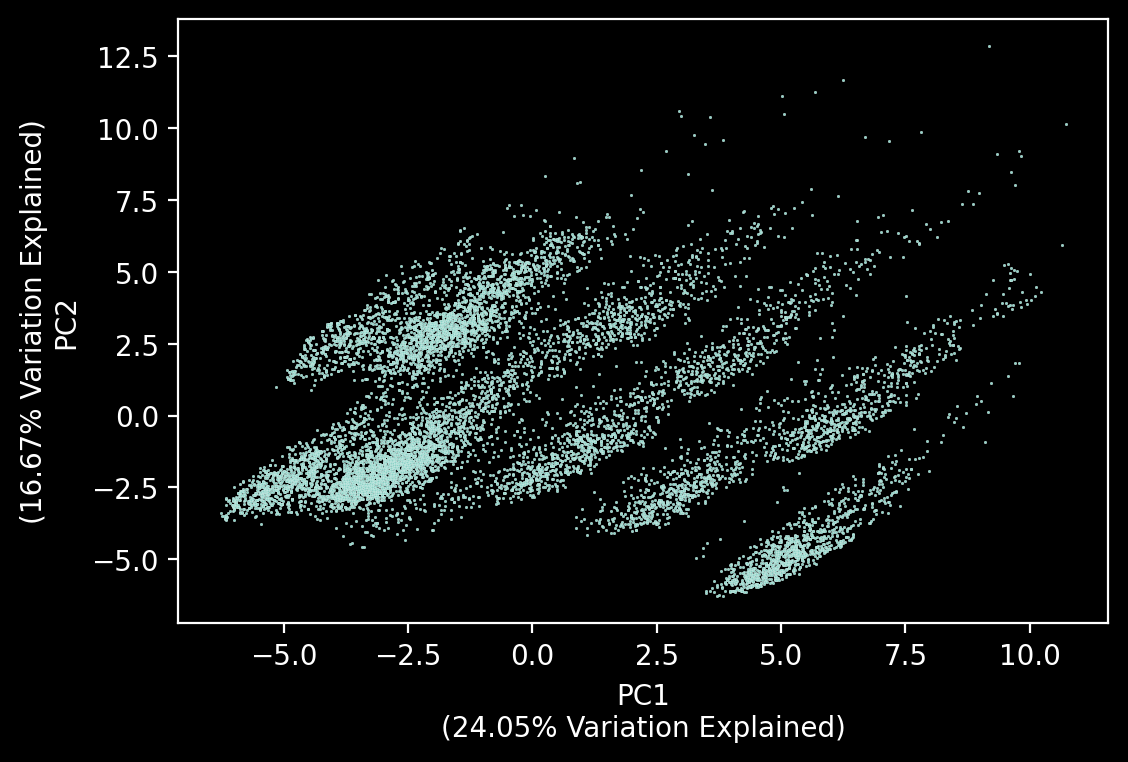

In [10]:
plt.figure(dpi=200)
sns.scatterplot(x=pca_df['1'], y=pca_df['2'], s=1)
plt.xlabel(f'PC1\n({gower_pca_transform.explained_variance_ratio_[0] * 100:.2f}% Variation Explained)')
plt.ylabel(f'({gower_pca_transform.explained_variance_ratio_[1] * 100:.2f}% Variation Explained)\nPC2')

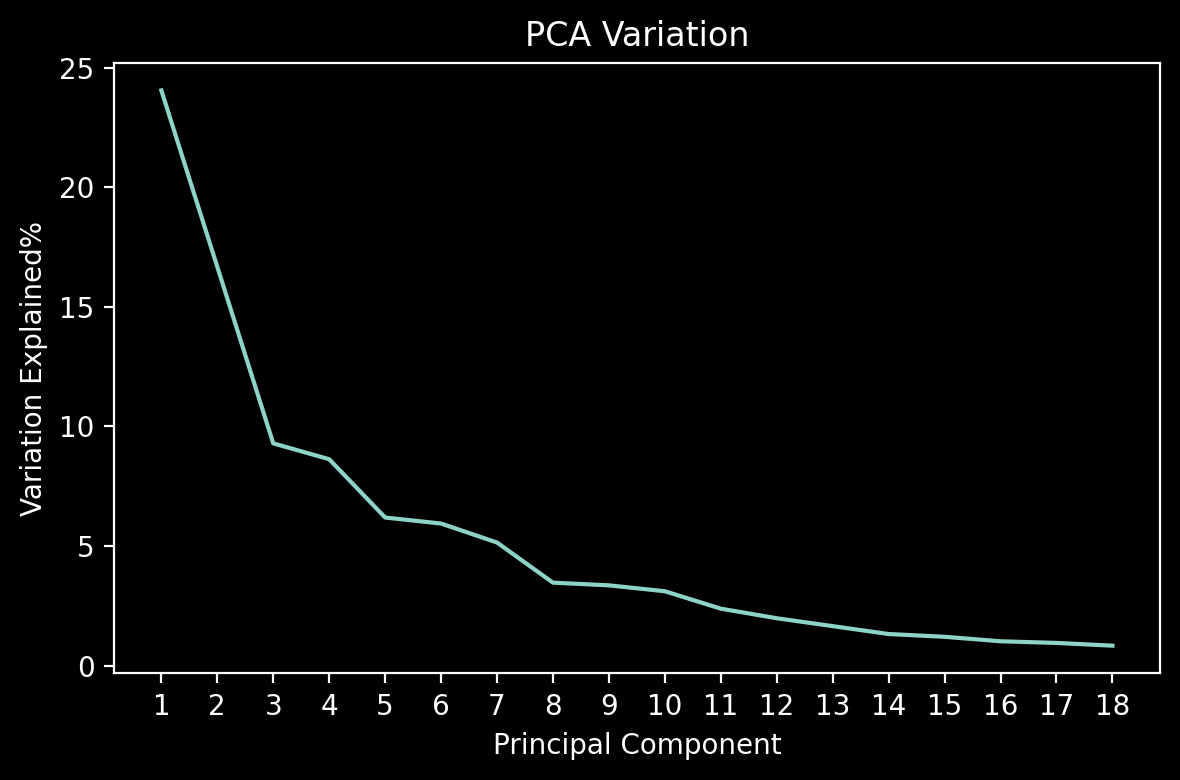

In [11]:
plt.figure(dpi=200)
sns.lineplot(x=pca_df.columns, 
             y=(gower_pca_transform.explained_variance_ratio_ * 100))
             
plt.title('PCA Variation')
plt.xlabel('Principal Component')
plt.ylabel('Variation Explained%')
plt.tight_layout()

### Clustering

In [12]:
def plot_clusters(X, y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=1,
                    label=f'cluster {cluster}',
                    cmap='colorblind')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend(loc=(1.01, 0.7))
    plt.show()

# plot_clusters(pca_customers, y_kmeans)

#### k-means

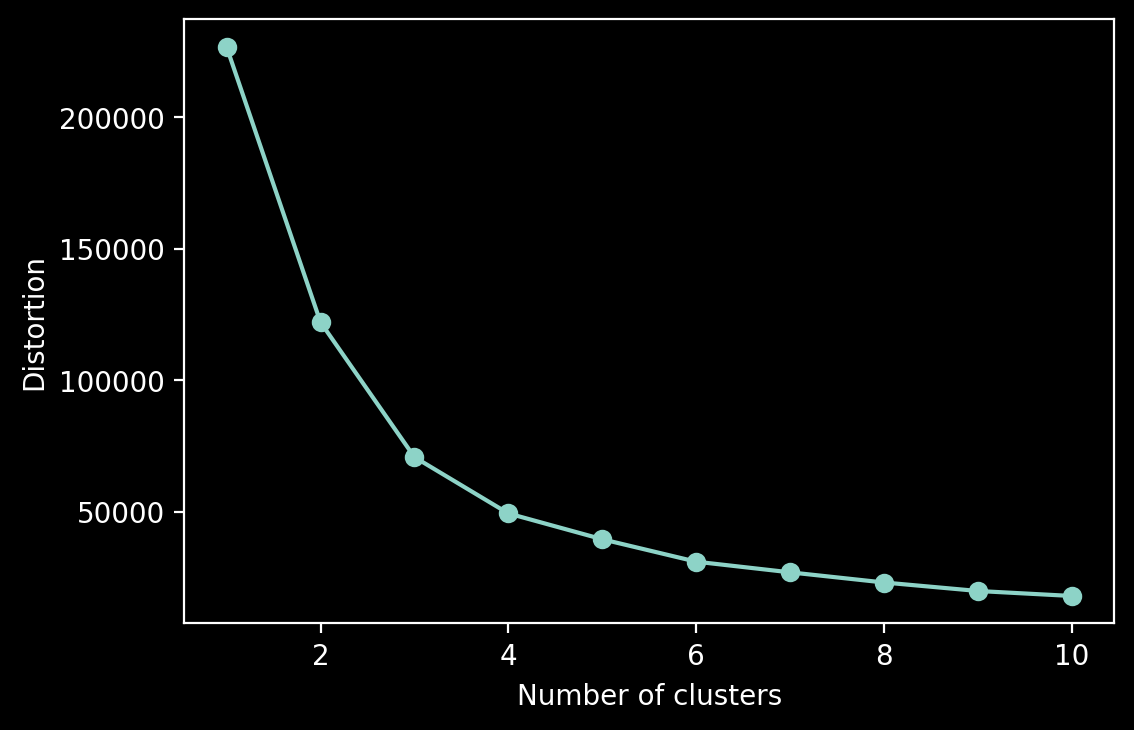

In [14]:
# Elbow rule suggests 3 clusters.

def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

plt.figure(dpi=200)
plot_distortion(pca_df[['1', '2']], max_clusters=10)

Elbow rule seems to suggest 3 or 4 for kmeans

##### 3 clusters

In [15]:
kmeans = KMeans(n_clusters=3,
                n_init=100)

In [16]:
y_kmeans = kmeans.fit_predict(gower_pca[:, :2])

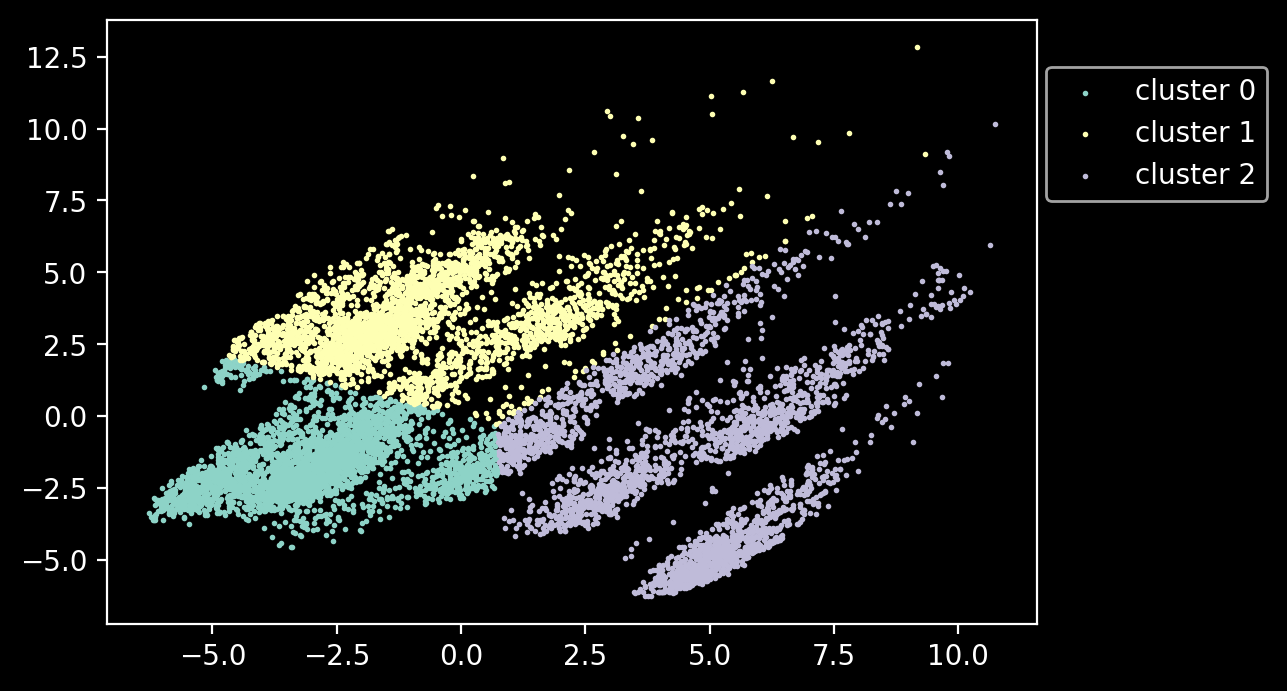

In [17]:
plt.figure(dpi=200)
plot_clusters(gower_pca[:, :2], y_kmeans)

##### 4 clusters

In [18]:
kmeans = KMeans(n_clusters=4,
                n_init=100,
                max_iter=2000)

In [19]:
y_kmeans = kmeans.fit_predict(gower_pca[:, :2])

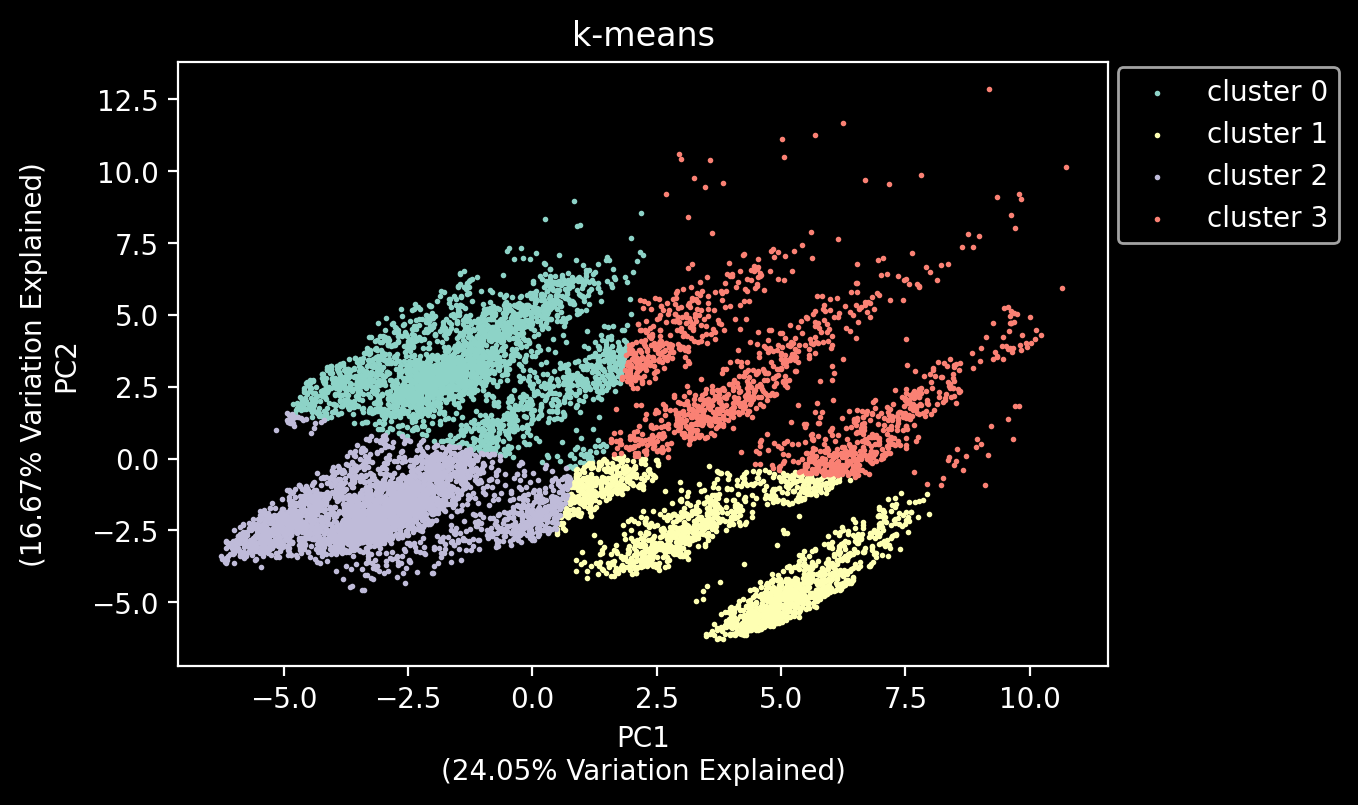

In [20]:
plt.figure(dpi=200)
plt.xlabel(f'PC1\n({gower_pca_transform.explained_variance_ratio_[0] * 100:.2f}% Variation Explained)')
plt.ylabel(f'({gower_pca_transform.explained_variance_ratio_[1] * 100:.2f}% Variation Explained)\nPC2')
plt.title('k-means')
plot_clusters(gower_pca[:, :2], y_kmeans)

##### 5 clusters

In [21]:
kmeans = KMeans(n_clusters=5,
                n_init=100,
                max_iter=2000)

In [22]:
y_kmeans = kmeans.fit_predict(gower_pca[:, :2])

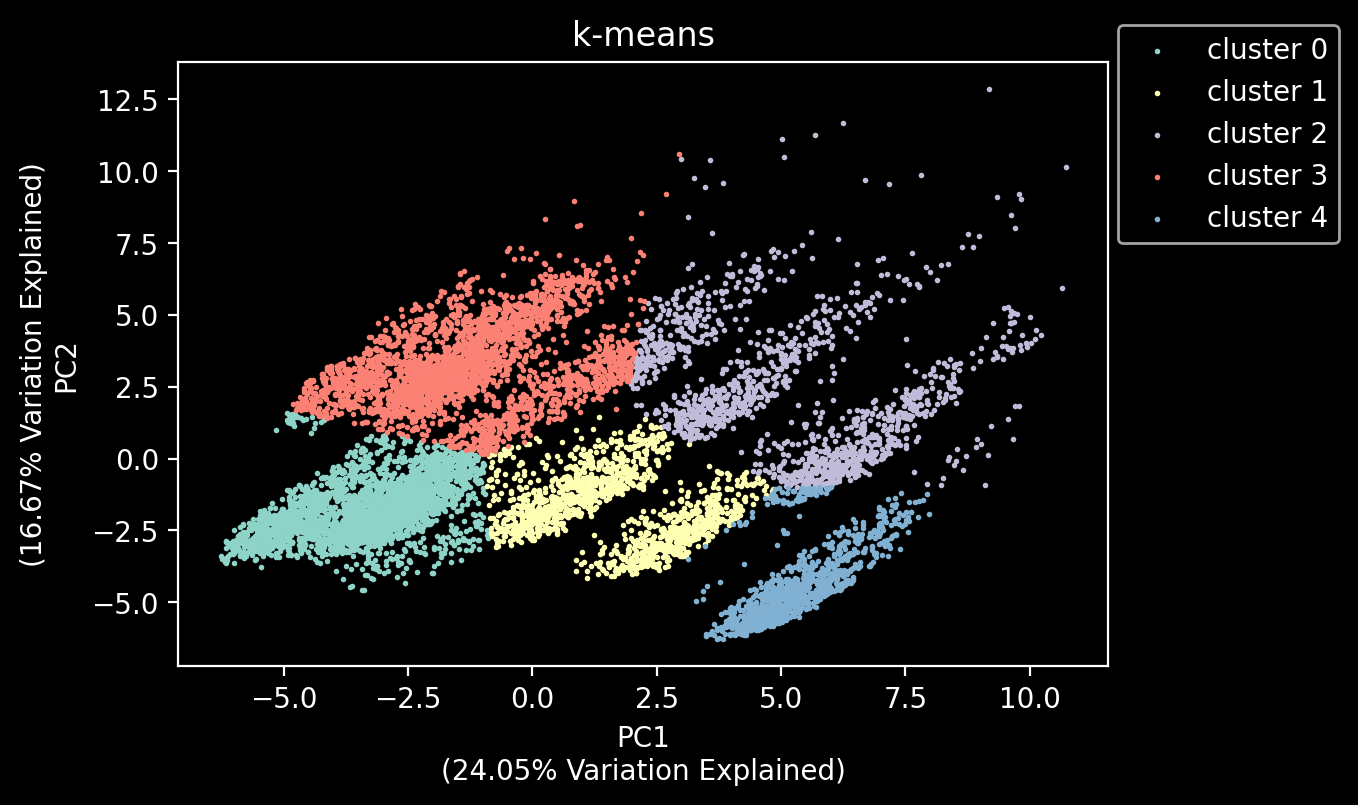

In [24]:
plt.figure(dpi=200)
plt.xlabel(f'PC1\n({gower_pca_transform.explained_variance_ratio_[0] * 100:.2f}% Variation Explained)')
plt.ylabel(f'({gower_pca_transform.explained_variance_ratio_[1] * 100:.2f}% Variation Explained)\nPC2')
plt.title('k-means')
plot_clusters(gower_pca[:, :2], y_kmeans)

#### DBSCAN

In [25]:
dbscan = DBSCAN(0.36, min_samples=7) # default params to start with

In [26]:
y_db = dbscan.fit_predict(gower_pca[:, :2])

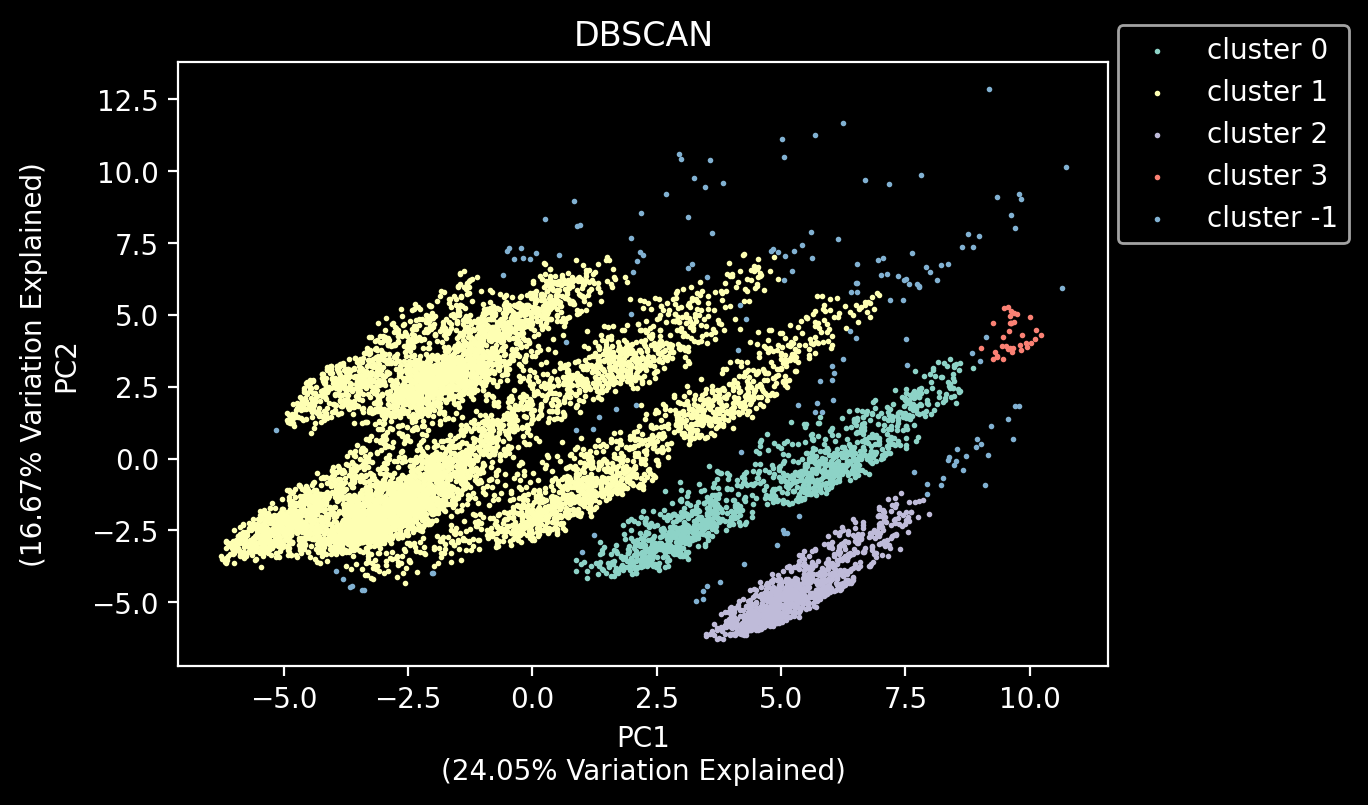

In [27]:
plt.figure(dpi=200)
plt.title('DBSCAN')
plt.xlabel(f'PC1\n({gower_pca_transform.explained_variance_ratio_[0] * 100:.2f}% Variation Explained)')
plt.ylabel(f'({gower_pca_transform.explained_variance_ratio_[1] * 100:.2f}% Variation Explained)\nPC2')
plot_clusters(gower_pca[:, :2], y_db)

#### Agglomerative

In [28]:
# define plot_dendrogram function
def plot_dendrogram(X,method ='ward'):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
         
    ax.plot(X)
    ax.set_title('Customer Segmentation')
    ax.set_ylabel('Euclidean Distances')
    ax.set_label('Points')
    plt.show()

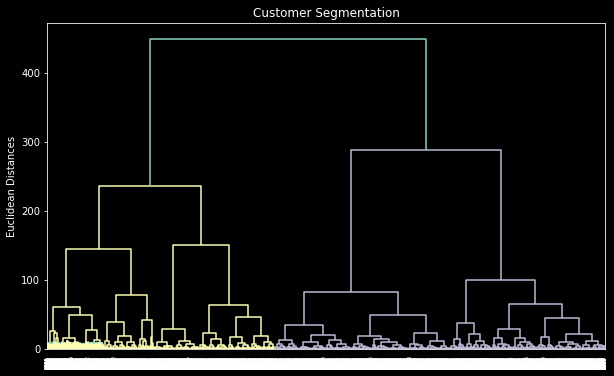

In [29]:
plot_dendrogram(gower_pca[:, :2])

Case for 3 or 4 clusters

##### 3 Clusters

In [30]:
ag_clust = AgglomerativeClustering(affinity='euclidean',
                                   linkage='ward',
                                   n_clusters = 3)

In [31]:
y_ag = ag_clust.fit_predict(gower_pca[:, :2])

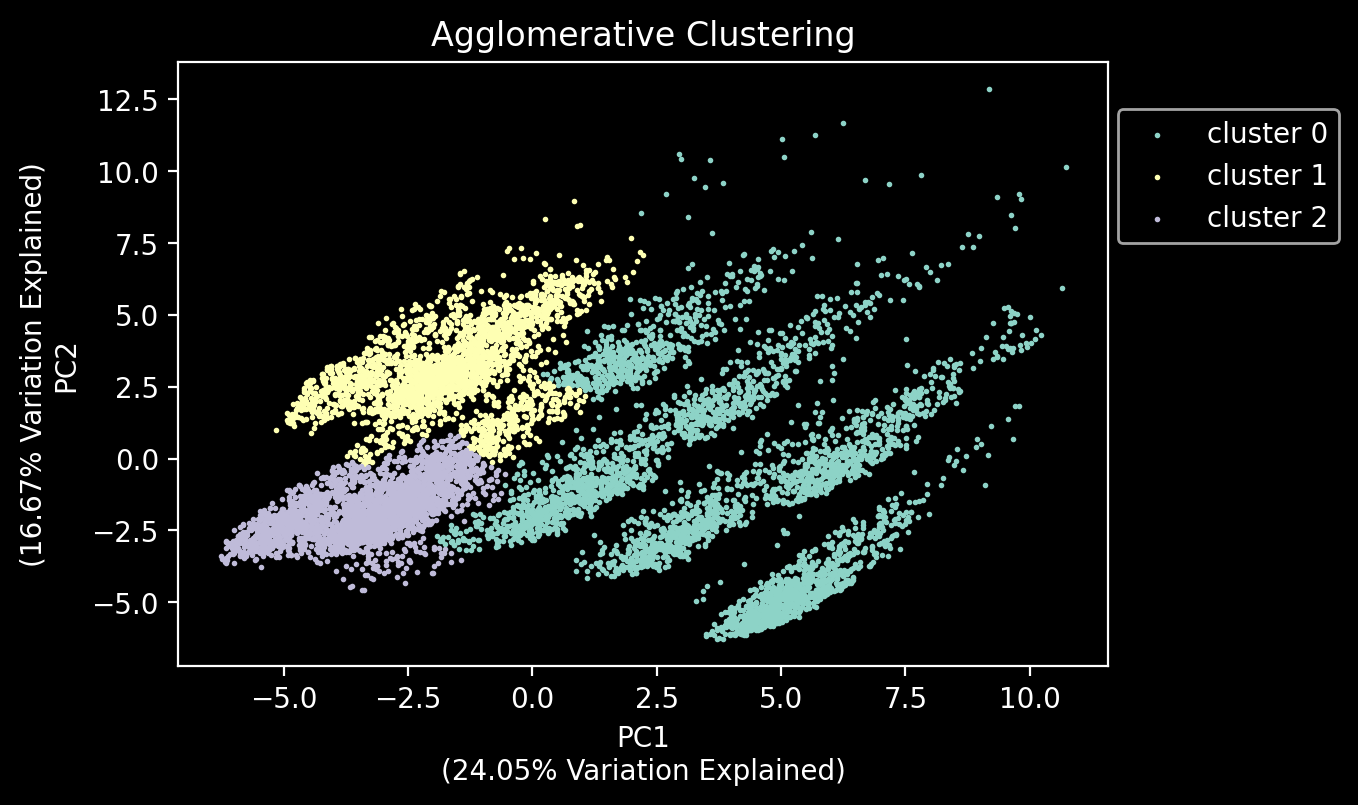

In [32]:
plt.figure(dpi=200)
plt.title('Agglomerative Clustering')
plt.xlabel(f'PC1\n({gower_pca_transform.explained_variance_ratio_[0] * 100:.2f}% Variation Explained)')
plt.ylabel(f'({gower_pca_transform.explained_variance_ratio_[1] * 100:.2f}% Variation Explained)\nPC2')
plot_clusters(gower_pca, y_ag)

##### 4 clusters

In [33]:
ag_clust = AgglomerativeClustering(affinity='euclidean',
                                   linkage='ward',
                                   n_clusters = 4)

In [34]:
y_ag = ag_clust.fit_predict(gower_pca[:, :2])

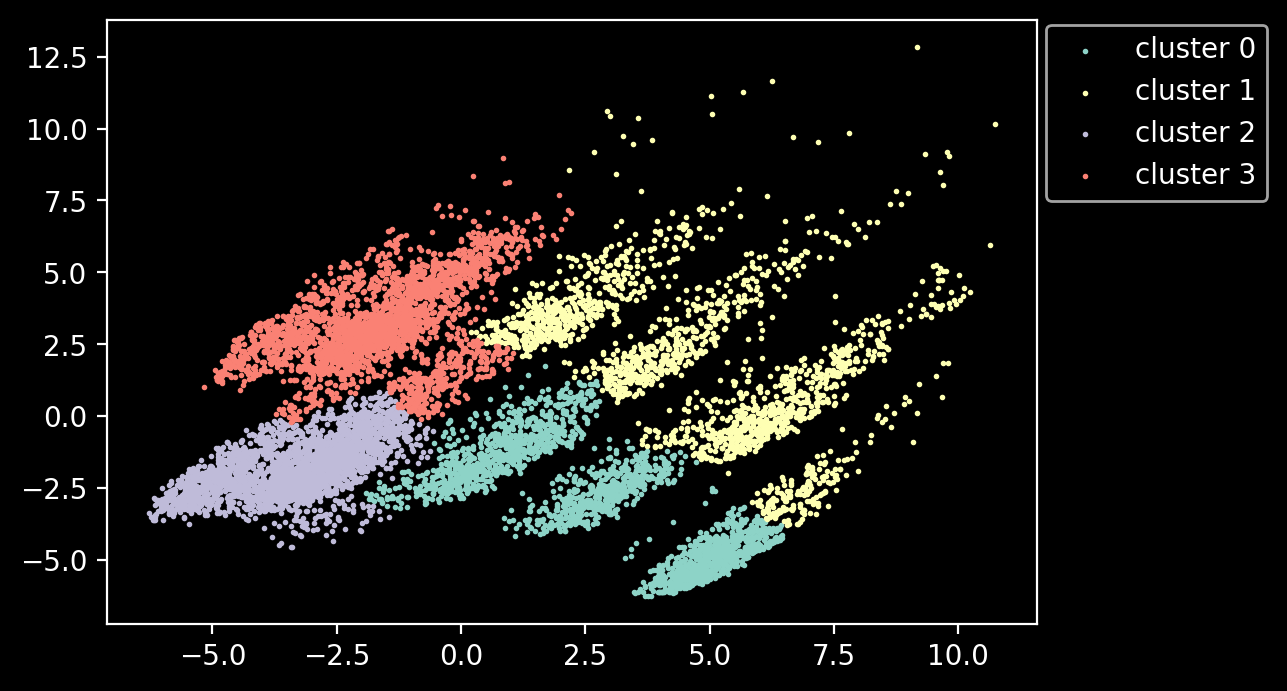

In [35]:
plt.figure(dpi=200)
plot_clusters(gower_pca, y_ag)